# Exploratory Data Analysis

&lt; Work in progress &gt;


In [2]:
%matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
# Not necessary, but I like the ggplot style better
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_08.csv')
df_com = pd.read_csv('comments_2017_08.csv').head(20000) # crop because battery life
# Make float better readable
pd.options.display.float_format = '{:.0f}'.format

### First Look

In [3]:
df_art.head(3)

,tId,article_id,updated,num_comments,link,header,sub,text
0,31538566,31538566,1502083635,0,/schweiz/news/story/31538566,«Für mich ist eine Welt zusammengebrochen»,Beim Flugzeugunglück bei Pontresina starben dr...,Im Bündner Diavolezza-Gebiet ist ein Flugzeug ...
1,19638181,19638181,1502197771,43,/schweiz/zuerich/story/19638181,Jetzt wird die Schwester der Europaallee gebaut,Gleisarena und Gleistribüne  so heissen die e...,Die neue Überbauung HB-Nord entsteht nördlich ...
2,31833243,31833243,1502299764,0,/schweiz/basel/story/Fuenffacher-Nachwuchs-im-...,Fünffacher Nachwuchs im Basler Affenhaus,Bei den Totenkopfäfflein im Basler Zoo gibt es...,Die fünf Totenkopfäffchen wurden zwischen Mitt...


In [4]:
df_com.head(3)

,tId,cId,mob,vup,vdo,tit,aut,time,con
0,24298157,3_127,1,2,0,@Thomas,Spaniel,am 21.07.2017 12:14,Es würde Streit geben wenn er aufgespannt wir...
1,13753138,1115_1225,0,21,1,ohne Partikelfilter,Heinz B.,am 05.08.2017 17:25,@Historiker: Aber im Gegensatz zu Baumaschine...
2,13340147,783_783,1,87,14,Nur Abzocker,KChav,am 09.08.2017 15:45,Jetzt kann die Zürcher Taxi Maffia wieder los...


In [5]:
print(df_art.shape)
print(df_com.shape)

(1026, 8)
(20000, 9)


In [6]:
print(df_art.dtypes)
print(' ')
print(df_com.dtypes)

tId               int64
article_id        int64
updated         float64
num_comments      int64
link             object
header           object
sub              object
text             object
dtype: object
 
tId      int64
cId     object
mob      int64
vup      int64
vdo      int64
tit     object
aut     object
time    object
con     object
dtype: object


In [7]:
df_art.describe()

# Summary:
# No missing attributes since count is the same everywhere
# No negative values, chi^2 etc. can be used

,tId,article_id,updated,num_comments
count,1026,1026,1026,1026
mean,21144399,21143338,1502274052,77
std,6430672,6435194,129408,136
min,10003016,10003016,1502017728,0
25%,15604268,15604268,1502172556,0
50%,21220790,21220790,1502288367,28
75%,26632181,26655490,1502414371,84
max,31996579,31996579,1502425549,1171


In [8]:
df_com.describe()

# Summary:
# No missing attributes 
# No negative values

,tId,mob,vup,vdo
count,20000,20000,20000,20000
mean,20876263,1,44,16
std,6447498,0,115,35
min,10003016,0,0,0
25%,15144608,0,7,2
50%,20500325,1,20,6
75%,26930870,1,44,16
max,31996579,1,3543,944


In [9]:
print(df_art.skew())
# Makes only sense on 'num_comments'

tId             0
article_id      0
updated        -0
num_comments    3
dtype: float64


In [10]:
print(df_com.skew())
# Skew is not high enough that it has to be corrected

tId    0
cId    3
mob   -1
vup   12
vdo    8
dtype: float64


### Feature Engineering
To make further analysis possible concerning time features.

In [11]:
from datetime import datetime

def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return (get_dt_obj(time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return get_dt_obj(time).hour

def get_weekday(time):
    return get_dt_obj(time).weekday()

# Basically same as "the hour of week" or "weekday_hourOfDay"
def get_weekday_float(time):
    hour = float(get_hour_of_day(time))
    weekday = get_weekday(time)
    return float(weekday) + hour / 24

def get_weekday_hour(time):
    return '{}_{}'.format(get_weekday(time), get_hour_of_day(time))

df_com['time_since_epoch'] = df_com['time'].apply(time_since_epoch)
df_com['hour'] = df_com['time'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time'].apply(get_weekday) # 0 = Monday
df_com['weekday_fl'] = df_com['time'].apply(get_weekday_float)
df_com['weekday_hour'] = df_com['time'].apply(get_weekday_hour)
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
df_com['con_len'] = df_com['con'].apply(lambda x: len(x))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['contr'] = df_com['vup'] + df_com['vdo']

### Class Distribution

In [12]:
# 'df_art' has no classes

# 'df_com' 
print(df_com.groupby('mob').size())
#print(df_com.groupby('hour').size())
print(df_com.groupby('weekday').size())

mob
0     6407
1    13593
dtype: int64
weekday
0    1711
1    2985
2    4381
3    3637
4    2354
5    2441
6    2491
dtype: int64


### Correlation
Let's find relations between some of the attributes. Correlation requires continuous data.

In [13]:
# Only for these columns
cols = ['score', 'contr', 'hour', 'weekday', 'weekday_fl', 'mob', 'vup', 'vdo', 'is_answer', 'con_len']

# Change back how float is displayed
pd.options.display.float_format = '{:.2f}'.format

# Get pearson co-efficients
df_corr = df_com[cols].corr()
df_corr

# Summary:
# Correlations are low.
# The only interesting correlation is between 'vup' and 'vdo'.

,score,contr,hour,weekday,weekday_fl,mob,vup,vdo,is_answer,con_len
score,1.00,0.85,-0.01,-0.01,-0.01,0.04,0.95,0.07,-0.14,0.01
contr,0.85,1.00,-0.01,-0.01,-0.01,0.08,0.97,0.59,-0.21,0.02
hour,-0.01,-0.01,1.00,-0.00,0.12,0.02,-0.01,-0.01,0.03,-0.06
weekday,-0.01,-0.01,-0.00,1.00,0.99,0.07,-0.01,-0.01,0.08,-0.02
weekday_fl,-0.01,-0.01,0.12,0.99,1.00,0.08,-0.01,-0.01,0.08,-0.03
mob,0.04,0.08,0.02,0.07,0.08,1.00,0.06,0.09,0.32,-0.13
vup,0.95,0.97,-0.01,-0.01,-0.01,0.06,1.00,0.37,-0.18,0.02
vdo,0.07,0.59,-0.01,-0.01,-0.01,0.09,0.37,1.00,-0.19,0.01
is_answer,-0.14,-0.21,0.03,0.08,0.08,0.32,-0.18,-0.19,1.00,-0.14
con_len,0.01,0.02,-0.06,-0.02,-0.03,-0.13,0.02,0.01,-0.14,1.00


### Scatter plots

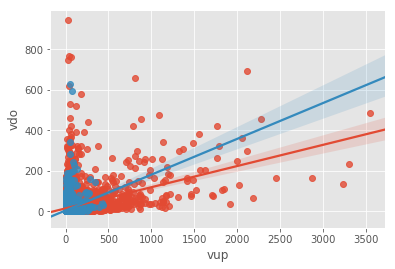

In [14]:
#sns.pairplot(df_com, x_vars='vup', y_vars='vdo', size=6)
sns.regplot(x='vup', y='vdo', data=df_com[df_com['is_answer'] == False])
sns.regplot(x='vup', y='vdo', data=df_com[df_com['is_answer'] == True])
plt.show()

# Quite some outliers
# Are rows with upvotes of over 1000 real?
# Looked some of them up manually and yes, they have a lot of upvotes (3000+)
# Answers are rather downvoted than upvoted (as can already be seen in the correlation matrix)

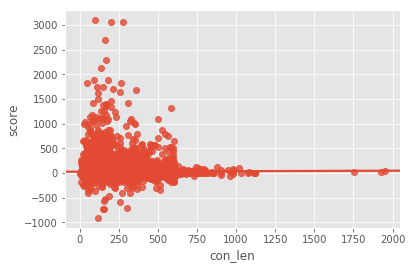

In [15]:
#sns.regplot(x='vup', y='vdo', data=df_com[df_com['vup'] < 200])
sns.regplot(x='con_len', y='score', data=df_com)
plt.show()

### Prediction
Ok... I want to know:
* How to get the best score/consensus (upvotes - downvotes)?
* How to be most controversial (upvotes + downvotes)?
* Which articles go most score / were most controversial (sum over all comments)?

...And in the end I want a model predicting my comment text with given day and hour of posting.

Impact will be taken into account from:
* Hour of comment
* Weekday
* Weekday + hour = Hour of week
* text written
* title written / if title is an answer (starts with "@")
* if from mobile (makes no sense, but let's see what happens)
* article text
* article category
* ...?

Problem:
* Some parts are computationally expensive / the ipython kernel has problems running it sometimes

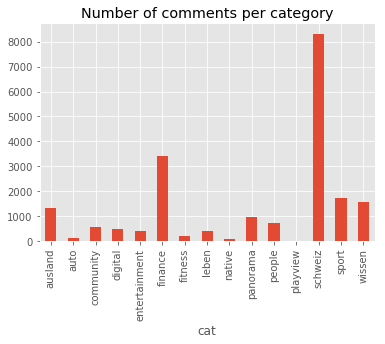

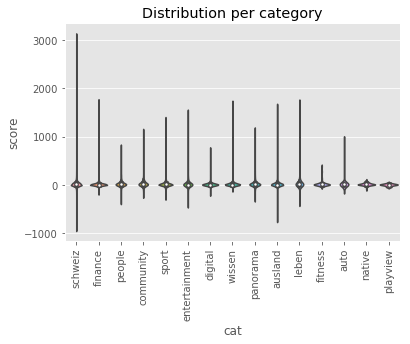

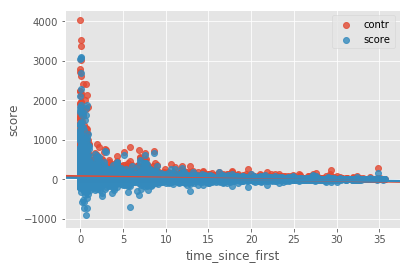

In [16]:
df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)

# Left inner join
df_merge = pd.merge(left=df_com, right=df_art, left_on='tId', right_on='tId')

# Hist
h = df_merge.groupby(['cat']).size()
h.plot.bar(title='Number of comments per category')
plt.show()

# Distribution
ax = sns.violinplot(x="cat", y="score", data=df_merge)
ax.set_title('Distribution per category')
plt.xticks(rotation = 90)
plt.show()

# Part of mobile users, not interesting enough
#parts_mob = df_merge[df_merge['mob'] == True].groupby(['cat']).size() / df_merge.groupby(['cat']).size()
#parts_mob.plot.bar(title='Mobile comments per category')
#plt.show()

# is empty: (= all comments correspond to an article)
#print(df_merge[pd.isnull(df_merge['link'])])
#df_merge[df_merge['vup']>1000]

# Get order of comments per article
df_merge_art = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')
# Get time since the first comment
def get_time_since_first(group):
    first = group.iloc[:1]['time_since_epoch']
    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)
    # Remove those very late comments, after x hours
    group = group[group['time_since_first'] < 36]
    return group

df_merge_art = df_merge_art.apply(get_time_since_first)

ax = sns.regplot(x='time_since_first', y='contr', label='contr', data=df_merge_art)
ax = sns.regplot(x='time_since_first', y='score', label='score', data=df_merge_art)
ax.legend()
plt.show()

    
# Summary:
# Score / contr are only possible in certain categories 
#    - the categories with lots of active users
#    - probably the categories with lots of comments (see hist)
# The time of posting compared to the first comment is not as important as I expected it to be
# Exception: Some early comments make it into "top comments" and get very high scores/contr
# But we can say the comment has to be posted about < ~12h after the first comment

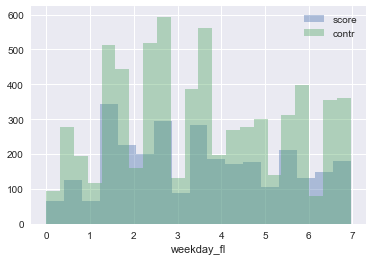

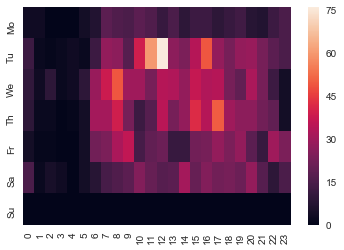

In [17]:
# Plot hist and heat map against weekdays
weekdays = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']

sns.set(color_codes=True)
ax = sns.distplot(df_com[df_com['score']>50]['weekday_fl'], label='score', kde=False)
ax = sns.distplot(df_com[df_com['contr']>50]['weekday_fl'], label='contr', kde=False)
#ax.set(xticks=range(0, len(weekdays)), xticklabels=weekdays) # This is misleading
ax.legend()
plt.show()
grouped = df_com[df_com['score']>50].groupby(['weekday', 'hour']).size()
matrix = np.zeros((7, 24))
for d in range(0, 6):
    for h in range(0, 24):
        if d in grouped and h in grouped[d]:
            matrix[d][h] = grouped[d][h]

sns.heatmap(matrix, yticklabels=weekdays)
plt.show()

# 0 = Monday, 7 = Sunday
# Summary:
# The day and time of posting plays a big role
# This is probably because on certain days upvoting people are most active
# This does not mean that posting the *same* comment on those times gives you more upvotes
# - it may be possible, but we can't imply that (yet? / not enough data)

In [18]:
# Preprocess and split data

# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für"
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns"
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower()
stop_words = stop_words.split(', ')

# Prepare data for X and y
#from sklearn.feature_extraction.text import CountVectorizer

# Preprocessor removes numbers
#no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
#vect = CountVectorizer(preprocessor=no_numbers, ngram_range=(1, 1), stop_words=stop_words) # Range higher than 1 doesn't help

def classify(val):
    if val > 50: return 1
    return 0

# TODO split this?
# For comments
if True:
    #X_words = vect.fit_transform(df_merge['con'])
    columns = ['weekday', 'hour', 'time_since_first', 'con_len']
    X = df_merge_art[columns + ['con', 'text']]
    #X = df_merge_art[columns]
    #X = df_merge_art[['weekday', 'hour', 'time_since_first', 'con_len', 'comb_weekday_hour', 'comb_hour_timesf']]
    #y = df_merge_art['score'].apply(classify)
    y = df_merge_art['score']
# For articles, some articles have no text
else:
    X = vect.fit_transform(df_merge[pd.notnull(df_merge['text'])]['text'])
    y = df_merge[pd.notnull(df_merge['text'])]['score'].apply(classify)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train_words, X_test_words, y_train_words, y_test_words = 

# Summary:
# Removing stop words didn't help the score (didn't add information), 
#   but it makes the model easier to interpret
# N-gram over 1 doesn't give a better score
# min_df / max_df in CountVectorizer make no difference

In [23]:
# Build model and test it
# Not all imports needed - trying around
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer, MinMaxScaler
from sklearn.metrics import r2_score, classification_report
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression
from sklearn.svm import SVC

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    '''
    Select a subset of data at a provided key.
    key: hashable, required
        The key corresponding to the desired value in a mappable.
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, df):
        return df[self.key]
    
no_numbers = lambda x: re.sub(r'(\d[\d\.])+', '', x.lower())
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list=
        [
            ('statistics', Pipeline([
                ('selector', ItemSelector(
                    key=['weekday', 'hour', 'time_since_first'])),
                ('scaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures(degree=5))
            ])),
            
            # TODO add sentiment analysis here
            # Course of dimensionality!!!
            #('words', Pipeline([
            #    ('selector', ItemSelector(key='con'),
            #    ('vect', CountVectorizer(preprocessor=no_numbers, ngram_range=(1, 1), stop_words=stop_words))
            #]))
        ],
        
        transformer_weights={
            'statistics': 1,
            #'words': .2
        }
    )),
    
    # Params not optimized yet
    ('model', Ridge())
    #('model', SVC(kernel='linear', n_jobs=-1))
])

#model = make_pipeline(ItemSelector(
#        key=['weekday', 'hour', 'time_since_first', 'con_len']),
#        StandardScaler(), PolynomialFeatures(degree=5), Ridge(alpha=100, max_iter=10, solver='cholesky'))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R^2: %1.3f\n" % r2_score(y_test, y_pred))
#print(classification_report(y_test, y_pred))

'''
# See influence of the polynomial features
print(columns)
features = {}
for i, feature in enumerate(model['union'].named_steps['polynomialfeatures'].get_feature_names()):
    features[feature] = model.named_steps['ridge'].coef_[i]

for name, value in sorted(features.items(), key=lambda x:x[1], reverse=True):
    print("{}\t{}".format(name, value))
'''

if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {'polynomialfeatures__degree': [2, 3, 4, 5],
        'ridge__alpha': np.logspace(-1, 4, 6), 'ridge__max_iter': [10, 50, 100], 'ridge__solver': ['svd', 'cholesky', 'lsqr']}
    grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best estimator:\n{}".format(grid.best_estimator_))
    #print("Best coefficients:\n{}".format(grid.best_estimator_.named_steps["ridge"].coef_))

R^2: 0.061



-----

-----

-----


### Beneath is old stuff!

Probably doesn't work anymore...

In [31]:
# CV to tune parameters
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

# This may take some time...
if False:
    from sklearn.model_selection import GridSearchCV
    param_grid = {'C': np.logspace(-3, 1, 5)}
    #param_grid = {'penalty': ['l2', 'elasticnet'], 'n_iter': [5, 10, 50], 'alpha': np.logspace(-5, 1, 5), 'n_jobs': [2]}
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=3)
    #grid = GridSearchCV(SGDClassifier(), param_grid, cv=4)
    grid.fit(X_train, y_train)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Best parameters: ", grid.best_params_)
    
# Summary:
# Even a score of 0.94 is still bad because it's from cross validation

Best cross-validation score: 0.85
Best parameters:  {'C': 0.001}


In [47]:
# Build and test a model with the parameters from above
from sklearn.metrics import r2_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.svm import SVC # just comparing to non-linear models 

model = LinearRegression()
#model = LogisticRegression(C=1e-3)
#model = SVC()
#model = SGDClassifier(penalty='l2', n_iter=50, alpha=1e-3, n_jobs=2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(y_pred)

print("\tR^2: %1.3f" % r2_score(y_test, y_pred))
if False: # class predictions only
    print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
    print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
    print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

# Summary:
#     Model overfits :(
#     I have to add the dependency from weekday and hour, since their influency is too big
#     ...now the words probably get weighted by the time they got posted

[ 31.61796717  29.18350035  48.2512597  ...,  26.28469895  38.21585969
  27.25588617]
	R^2: 0.021


In [23]:
# Understand how coefficients are set / which words are important
print(logreg.coef_)
coeff_by_name = {}
for i, f in enumerate(vect.get_feature_names()):
    coeff_by_name[f] = logreg.coef_[:, i][0]

coeff_sorted = sorted(coeff_by_name.items(), key=lambda x:x[1], reverse=True)

for c in coeff_sorted[0:30]:
    print("{}\t{}".format(c[0], c[1]))
print("----------")
for c in coeff_sorted[-30:]:
    print("{}\t{}".format(c[0], c[1]))

# Summary comments:
# It seems that making positive comments about something bad that happened
#     gives a lot of upvotes
# Downvotes seem to be received for grumbling and arguing

# Summary articles:
# ~ Ranting about the 20min app etc. gives downvotes
# ~ Ranting about weapons, police, showing sympathy gives upvotes



[[-0.21534871 -0.08570709 -0.51195525]]


NotFittedError: CountVectorizer - Vocabulary wasn't fitted.

### Take Aways so far
Context seems to play a big role in determining up/downvotes, a far bigger role than words used. - This is not surprising, since the number of active readers differs a lot and since words can change their meaning depending on context.  
So maybe the content is not that important, maybe it's more important if it is positive or negative?  
Hypothesis: Earlier comments on an article get more score/contr than later ones (have to check that).

Next steps:
* Build a model for sentiment analysis (maybe start with a simple one, classifying with certain words)
* Explore for and then maybe build prediction model with features: weekday and hour of posting, order of comment (let's continuous first), length of comment (maybe), if it's a positive, neutral or negative one